# Notes

Similar feature sets as iteration 1, except that we remove records that are considered as outliers at least in one column.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

sns.set_context('talk')

RND = 121

In [2]:
FILE_NAME = "df_train_rfe.csv"

input_train_path = os.path.join(
    '..',
    '..',
    'dataset',
    'feature-engineering',
    FILE_NAME
)

df_train = pd.read_csv(input_train_path)
df_train.head()

input_test_path = os.path.join(
    '..',
    '..',
    'dataset',
    'feature-engineering',
    FILE_NAME.replace('train','test')
)
df_test = pd.read_csv(input_test_path)
df_test.head()

,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,...,payments,age,lastOrder,availability_completely_orderable,address_1,address_2,time_of_day_afternoon,time_of_day_evening,onlineStatus_-99,order
0,6.0,6.0,148.694,14.0,11.99,26.99,261.88,3.0,11.99,26.99,...,-99.0,-99.0,-99.0,0,0,0,0,0,1,1
1,21.0,5.0,502.445,15.0,29.99,49.99,629.85,4.0,29.99,49.99,...,4.0,60.0,13.0,1,0,1,0,1,0,1
2,21.0,6.0,2268.294,33.0,4.99,19.99,373.76,5.0,5.00,17.99,...,1.0,55.0,230.0,1,0,1,0,1,0,1
3,9.0,6.0,98.096,5.0,19.99,34.99,129.95,5.0,19.99,34.99,...,0.0,51.0,552.0,1,0,1,0,0,0,1
4,8.0,7.0,548.471,6.0,9.99,39.99,119.95,4.0,9.99,39.99,...,88.0,41.0,5.0,0,1,0,0,0,1,1


# Prepare training and test set

In [3]:
row_count = df_train.shape[0]
row_count

238878

In [4]:
df_train.iloc[0]

startHour                              16.000
startWeekday                            5.000
duration                               84.495
cCount                                  7.000
cMinPrice                               3.990
cMaxPrice                              29.990
cSumPrice                             183.930
bCount                                  1.000
bMinPrice                              29.990
bMaxPrice                              29.990
bSumPrice                              29.990
bStep                                 -99.000
maxVal                               2500.000
customerScore                         582.000
accountLifetime                       359.000
payments                               13.000
age                                    72.000
lastOrder                             146.000
availability_completely_orderable       0.000
address_1                               1.000
address_2                               0.000
time_of_day_afternoon             

In [5]:
categorical_feature_list_initial = [
    'availability_-99', 'availability_completely_not_determinable',
    'availability_completely_not_orderable','availability_completely_orderable',
    'availability_mainly_not_determinable','availability_mainly_not_orderable', 
    'availability_mainly_orderable',
    'address_-99', 'address_1', 'address_2', 
    'time_of_day_afternoon','time_of_day_early_morning', 'time_of_day_evening', 
    'onlineStatus_-99','onlineStatus_0'
]

categorical_feature_list = []
for col in categorical_feature_list_initial:
    try:
        df_train[col] = df_train[col].astype(int)
        df_test[col] = df_test[col].astype(int)
        categorical_feature_list.append(col)
    except:
        print(f"{col} doesn't exist!")
        continue

availability_-99 doesn't exist!
availability_completely_not_determinable doesn't exist!
availability_completely_not_orderable doesn't exist!
availability_mainly_not_determinable doesn't exist!
availability_mainly_not_orderable doesn't exist!
availability_mainly_orderable doesn't exist!
address_-99 doesn't exist!
time_of_day_early_morning doesn't exist!
onlineStatus_0 doesn't exist!


In [6]:
target_class = 'order'

y_train = df_train[target_class].copy()
X_train = df_train.drop(labels=[target_class], axis=1)

y_test = df_test[target_class].copy()
X_test = df_test.drop(labels=[target_class], axis=1)

In [7]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(238878, 24) (238878,)
(128704, 24) (128704,)


In [8]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score

def evaluate_performance(y_true, y_pred, print_results = True):
    accuracy = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    if print_results:
        print(f"Accuracy : {accuracy:.3%}")
        print(f"F1-score : {f_score:.3%}")
        print(f"AUC: {auc:.3f}")
        print(classification_report(y_true, y_pred))
        
    return accuracy, f_score, auc

In [9]:
from sklearn.model_selection import KFold

def kfold_cv(clf, X_train, y_train, k = 10):
    kfold = KFold(random_state = RND, shuffle = True, n_splits = k)
    
    cv_accuracy = np.zeros(shape=k)
    cv_f1 = np.zeros(shape=k)
    cv_auc = np.zeros(shape=k)
    
    i = 0
    for train_index, val_index in kfold.split(X_train):
        X_tr = X_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        X_val = X_train.loc[val_index]
        y_val = y_train.loc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        accuracy, f_score, auc = evaluate_performance(y_val, y_pred, print_results = False)
        print(f"Iteration {i+1}: Accuracy={accuracy:.3%} | F1-score={f_score:.3%} | AUC={auc:.3f}")
        
        cv_accuracy[i] = accuracy
        cv_f1[i] = f_score
        cv_auc[i] = auc
        
        i += 1
    
    print("Cross-validation results")
    print("========================")
    print(f"Accuracy: {np.mean(cv_accuracy):.3%} +- {np.std(cv_accuracy):.3%}")
    print(f"F1-score: {np.mean(cv_f1):.3%} +- {np.std(cv_f1):.3%}")
    print(f"AUC: {np.mean(cv_auc):.3f} +- {np.std(cv_auc):.3f}")

# Model Training and Evaluation



# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    random_state=RND,
    n_estimators=300,
    max_depth=30,
    min_samples_split=2,
)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_rf, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_rf.fit(X_train, y_train)

Iteration 1: Accuracy=92.017% | F1-score=92.099% | AUC=0.920
Iteration 2: Accuracy=91.962% | F1-score=92.154% | AUC=0.920
Iteration 3: Accuracy=91.898% | F1-score=92.065% | AUC=0.919
Iteration 4: Accuracy=91.931% | F1-score=92.096% | AUC=0.919
Iteration 5: Accuracy=92.123% | F1-score=92.234% | AUC=0.921
Cross-validation results
Accuracy: 91.986% +- 0.079%
F1-score: 92.130% +- 0.060%
AUC: 0.920 +- 0.001


RandomForestClassifier(max_depth=30, n_estimators=300, random_state=121)

In [11]:
y_pred = model_rf.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 82.506%
F1-score : 87.581%
AUC: 0.777
              precision    recall  f1-score   support

           0       0.78      0.64      0.70     41947
           1       0.84      0.92      0.88     86757

    accuracy                           0.83    128704
   macro avg       0.81      0.78      0.79    128704
weighted avg       0.82      0.83      0.82    128704



In [12]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 121,
 'verbose': 0,
 'warm_start': False}

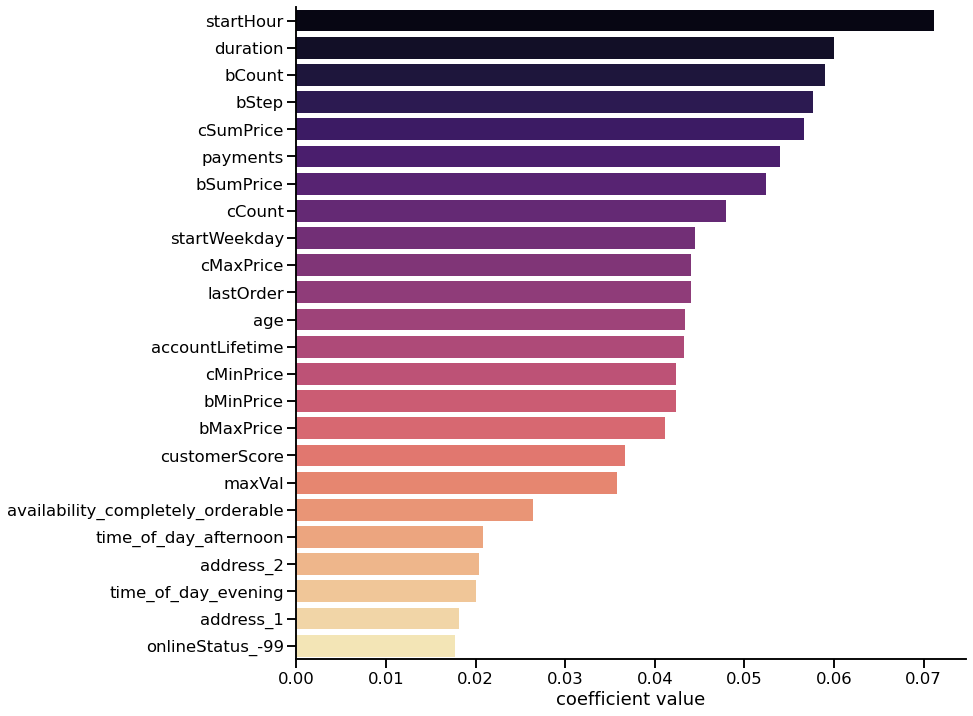

In [13]:
rf_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_rf.feature_importances_
    }
).sort_values(by='coef', ascending=False)
rf_coef['coef_abs'] = np.abs(rf_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=rf_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();